[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/XANESNN/blob/main/e3nn-xanes.ipynb)

# Predicting K-edge XANES with E(3)NN

## Colab Setup

- Go to Runtime > Change runtime type, and select GPU.
- Clone the GitHub repository to access the tutorial files:

In [ ]:
!git clone https://github.com/ninarina12/XANESNN.git
%cd XANESNN

- Install the relevant packages:

In [ ]:
!pip install ase pymatgen cmcrameri e3nn
!pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric

## Package imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter

from ase import Atom
from ase.data import atomic_masses

from tqdm import tqdm
from utils.data import XANES, Process, bar_format
from utils.e3nn import Network

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
device = "cuda:0"

In [2]:
if not os.path.exists('images/'):
    os.makedirs('images/')
    
if not os.path.exists('models/'):
    os.makedirs('models/')

## Load and process data

In [3]:
# Load data
data_file = 'data/Ni_K_XANES_averaged_simplified.json'
xanes = XANES()
xanes.load_data(data_file)
xanes.data

Number of samples: 2842


,structure,spectrum,formula_pretty
0,"[[5.543865 5.543865 5.543865] Ac, [1.847955 1....","{'x': [8335.8, 8336.263, 8336.678, 8337.044, 8...",Ac2NiIr
1,"[[5.7118125 5.7118125 5.7118125] Ac, [1.903937...","{'x': [8335.389, 8335.852, 8336.267, 8336.633,...",Ac2NiGe
2,"[[0. 0. 0.] Ni, [2.001977 2.001977 2.001977] A...","{'x': [8333.833, 8334.296, 8334.71, 8335.076, ...",NiAgF3
3,"[[ 1.504977 -0.86890074 3.95156027] Ni, [ 1...","{'x': [8334.728, 8335.191, 8335.606, 8335.971,...",Ni2Ag3O4
4,"[[0. 0. 0.] Ni, [18.20739637 0. 2.04...","{'x': [8334.712, 8335.175, 8335.589, 8335.955,...",Ni(AgO)2
...,...,...,...
2837,"[[1.583357 1.583357 1.583357] Sc, [0. 0. 0.] Ni]","{'x': [8339.397, 8339.861, 8340.275, 8340.641,...",ScNi
2838,"[[ 2.657819 -1.5344954 3.2288895] Zr, [2.657...","{'x': [8338.461, 8338.925, 8339.339, 8339.705,...",ZrNi3
2839,"[[5.730893 0. 0. ] Zn, [2.8654465 2...","{'x': [8336.839, 8337.303, 8337.717, 8338.083,...",Zn(GaNi)3
2840,"[[-2.53717094 4.59002127 11.89782002] Li, [2....","{'x': [8334.66, 8335.123, 8335.538, 8335.903, ...",Li2Ni4OF8


In [4]:
# TO DO: Interpolate XANES data to uniform energy bins

100%|██████████| 2842/2842 [00:00<00:00, 5613.68it/s]                             


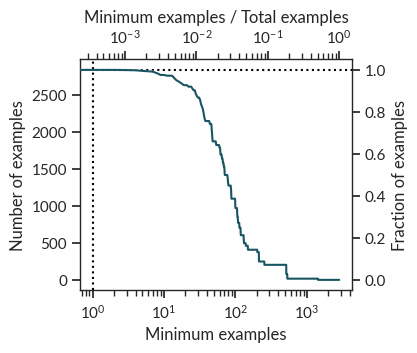

In [4]:
# Enforce a minimum number of examples of each specie
species_min = 1

xanes.get_species_counts()
fig = xanes.plot_species_counts(species_min)
#xanes.set_species_counts(species_min)
#xanes.get_species_counts()
#xanes.savefig('images/species_counts.svg', bbox_inches='tight')

Average lattice parameter (a/b/c): 6.582708692392623 / 6.999373774964122 / 8.58736803655871


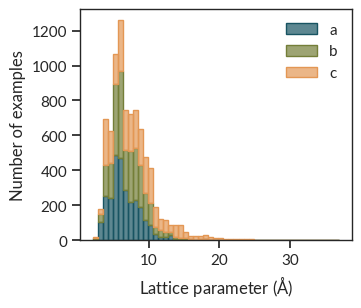

In [5]:
# Lattice parameter statistics
xanes.get_lattice_parameters()
fig = xanes.plot_lattice_parameters(n_bins=50)
#fig.savefig('images/lattice_parameters.svg', bbox_inches='tight')

## Format input features

In [6]:
# Get species
species = sorted(list(set(xanes.data['species'].sum())))
n_species = list(np.unique(xanes.data['species'].sum(), return_counts=True)[1])
Z_max = max([Atom(k).number for k in species])
print(Z_max)

94


In [7]:
# One-hot encoding atom type and mass
type_encoding = {}
mass_specie = []

for Z in tqdm(range(1, Z_max + 1), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    mass_specie.append(atomic_masses[Z])

type_onehot = torch.eye(len(type_encoding))
mass_onehot = torch.diag(torch.tensor(mass_specie))

100%|██████████| 94/94 [00:00<00:00, 364722.09it/s]                               


In [8]:
# Process data into input descriptors
process = Process(species, Z_max, type_encoding, type_onehot, mass_onehot, default_dtype)

r_max = 5.     # cutoff radius
tqdm.pandas(desc='Building data', bar_format=bar_format)
xanes.data['input'] = xanes.data.progress_apply(lambda x: process.build_data(x, r_max), axis=1)

Building data: 100%|██████████| 2842/2842 [01:05<00:00, 43.41it/s]                


## Format training, validation, and test sets

Split train/dev ...


100%|██████████| 83/83 [00:00<00:00, 375.26it/s]                                  


Split valid/test ...


100%|██████████| 83/83 [00:00<00:00, 629.69it/s]                                  


Number of training examples: 1687
Number of validation examples: 538
Number of testing examples: 617
Total number of examples: 2842


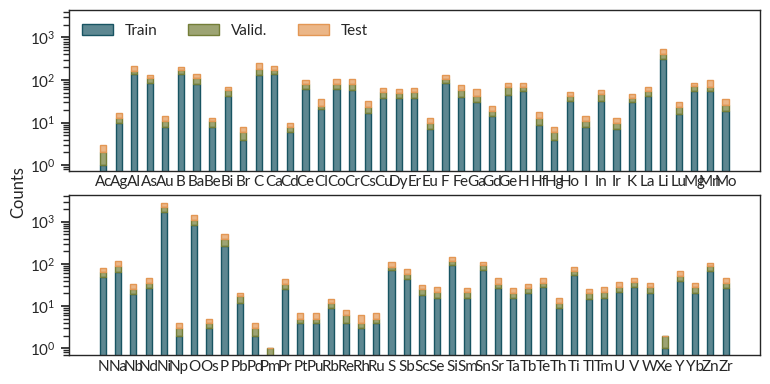

In [9]:
# Train/valid/test split
test_size = 0.2
fig = process.train_valid_test_split(xanes.data, valid_size=test_size, test_size=test_size, plot=True)
#fig.savefig('images/train_valid_test_split.svg', bbox_inches='tight')

Average number of neighbors (train/valid/test): 43.461830396091436 / 42.746196957566056 / 43.77496256364181


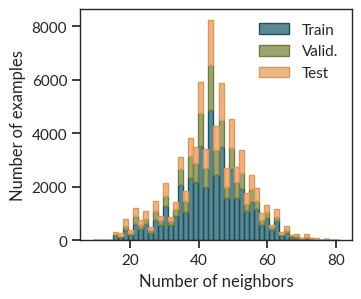

In [10]:
# Calculate average number of neighbors
process.get_neighbors(xanes.data)
fig = process.plot_neighbors(n_bins=50)
print('Average number of neighbors (train/valid/test):', process.n_train.mean(), '/',
                                                         process.n_valid.mean(), '/',
                                                         process.n_test.mean())
#fig.savefig('images/num_neighbors.svg', bbox_inches='tight')

In [11]:
# Format dataloaders
batch_size = 16
dataloader_train = tg.loader.DataLoader(xanes.data.iloc[process.idx_train]['input'].tolist(), batch_size=batch_size,
                                        shuffle=True)
dataloader_valid = tg.loader.DataLoader(xanes.data.iloc[process.idx_valid]['input'].tolist(), batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(xanes.data.iloc[process.idx_test]['input'].tolist(), batch_size=batch_size)

## Build neural network model

In [12]:
class E3NN(Network):
    def __init__(self, in_dim, out_dim, emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers,
                 radial_neurons, num_neighbors):
        kwargs = {'reduce_output': False,
                  'irreps_in': str(emb_dim)+"x0e",
                  'irreps_out': str(out_dim)+"x0e",
                  'irreps_node_attr': str(emb_dim)+"x0e",
                  'layers': num_layers,
                  'mul': mul,
                  'lmax': lmax,
                  'max_radius': max_radius,
                  'number_of_basis': num_basis,
                  'radial_layers': radial_layers,
                  'radial_neurons': radial_neurons,
                  'num_neighbors': num_neighbors
                 }
        super().__init__(**kwargs)
        
        # definitions
        self.cmap = plt.get_cmap('plasma')
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.num_basis = num_basis
        self.radial_layers = radial_layers
        self.radial_neurons = radial_neurons
        self.num_neighbors = num_neighbors
        
        self.model_name = 'e3nn-xanes_' + '_'.join(i + str(int(j)) for (i,j) in zip(
            ['emb', 'layers', 'mul', 'lmax', 'rmax', 'nbasis', 'rlayers', 'rneurons'],
            [emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers, radial_neurons]))
        
        # embedding
        self.emb_x = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.ReLU()
        )
        
        self.emb_z = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.Tanh()
        )
        
    
    def forward(self, data):
        data['x'] = self.emb_x(data['x_in'])
        data['z'] = self.emb_z(data['z_in'])
        x = super().forward(data)[0]
        
        # aggregate
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        y = torch_scatter.scatter_mean(x, batch, dim=0)
        return y
    
    
    def count_parameters(self): 
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    

    def loss(self, y_pred, y_true):
        return nn.MSELoss()(y_pred, y_true)
    
    
    def checkpoint(self, dataloader, device):
        self.eval()
        
        loss_cum = 0.
        with torch.no_grad():
            for j, d in enumerate(dataloader):
                d.to(device)
                y_pred = self.forward(d)

                loss = self.loss(y_pred, d.y).cpu()
                loss_cum += loss.detach().item()
                
        return loss_cum/len(dataloader)

    
    def fit(self, opt, dataloader_train, dataloader_valid, history, s0, max_iter=10, device="cpu", scheduler=None):
        chkpt = 1

        for step in range(max_iter):
            self.train()

            loss_cum = 0.
            start_time = time.time()

            for j, d in enumerate(dataloader_train):
                d.to(device)
                y_pred = self.forward(d)

                loss = self.loss(y_pred, d.y).cpu()
                loss_cum += loss.detach().item()
                
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"batch loss = {loss.data:.4e}", end="\r", flush=True)
                
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            if scheduler is not None:
                scheduler.step()
            
            end_time = time.time()
            wall = end_time - start_time

            if (step+1)%chkpt == 0:
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"epoch loss = {loss_cum/len(dataloader_train):.4e}")

                loss_valid = self.checkpoint(dataloader_valid, device)
                loss_train = self.checkpoint(dataloader_train, device)

                history.append({
                    'step': step + s0,
                    'wall': wall,
                    'batch': {
                        'loss': loss.item(),
                    },
                    'valid': {
                        'loss': loss_valid,
                    },
                     'train': {
                         'loss': loss_train,
                     },
                })

                yield {
                    'history': history,
                    'state': self.state_dict(),
                    'optimizer': opt.state_dict(),
                    'scheduler': scheduler.state_dict() if scheduler else None
                }

In [13]:
args_enn = {'in_dim': Z_max,
            'out_dim': xanes.data.iloc[0]['input'].y.shape[-1],
            'emb_dim': 64,
            'num_layers': 2,
            'mul': 32,
            'lmax': 2,
            'max_radius': r_max,
            'num_basis': 10,
            'radial_layers': 1,
            'radial_neurons': 100,
            'num_neighbors': process.n_train.mean(),
           }

enn = E3NN(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=3e-3)
scheduler = None #torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

model_num = 0
model_path = 'models/' + enn.model_name + '_' + str(model_num) + '.torch'

print(model_path)
#print(enn)
print('Number of parameters:', enn.count_parameters())

/home/nandrejevic/anaconda3/envs/e3nn05/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


models/e3nn-xanes_emb64_layers2_mul32_lmax2_rmax5_nbasis10_rlayers1_rneurons100_0.torch
Number of parameters: 4974392


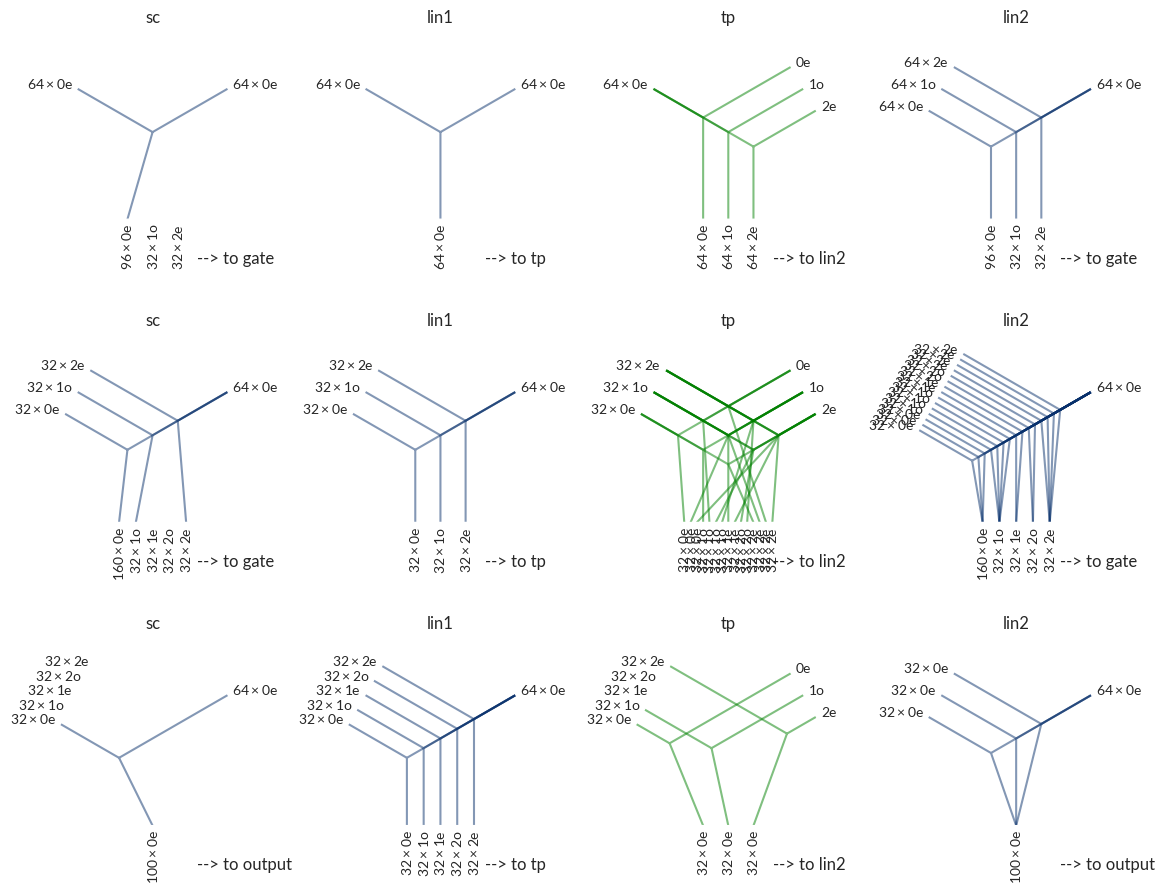

In [14]:
fig = enn.visualize()

## Train model

In [15]:
resume = False
    
if resume:
    saved = torch.load(model_path, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1

else:
    history = []
    s0 = 0

In [39]:
# fit E3NN
for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=20, device=device,
                       scheduler=scheduler):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration     1    batch   106 /   106   epoch loss = 2.4572e-01
Iteration     2    batch   106 /   106   epoch loss = 5.3013e-02
Iteration     3    batch   106 /   106   epoch loss = 4.9204e-02
Iteration     4    batch   106 /   106   epoch loss = 4.3665e-02
Iteration     5    batch   106 /   106   epoch loss = 4.4405e-02
Iteration     6    batch   106 /   106   epoch loss = 4.5871e-02
Iteration     7    batch   106 /   106   epoch loss = 4.9167e-02
Iteration     8    batch   106 /   106   epoch loss = 4.4290e-02
Iteration     9    batch   106 /   106   epoch loss = 4.3498e-02
Iteration    10    batch   106 /   106   epoch loss = 4.2800e-02
Iteration    11    batch   106 /   106   epoch loss = 4.0915e-02
Iteration    12    batch   106 /   106   epoch loss = 3.9118e-02
Iteration    13    batch   106 /   106   epoch loss = 3.3856e-02
Iteration    14    batch   106 /   106   epoch loss = 3.5936e-02
Iteration    15    batch   106 /   106   epoch loss = 2.5711e-02
Iteration    16    batch 

In [70]:
if not os.path.exists('images/' + enn.model_name + '_' + str(model_num)):
    os.makedirs('images/' + enn.model_name + '_' + str(model_num))

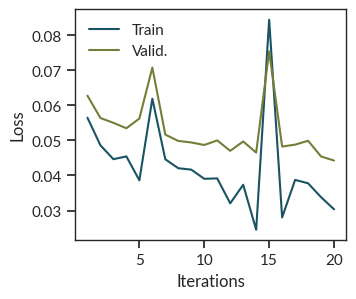

In [16]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color=process.colors['Train'])
ax.plot(steps, loss_valid, label='Valid.', color=process.colors['Valid.'])

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
#ax.set_yscale('log')
#fig.savefig('images/' + enn.model_name + '_' + str(model_num) + '/loss.svg', bbox_inches='tight')

## Evaluate model